In [1]:
!git clone https://github.com/yucaoyc/OptimalDiffusion.git


Cloning into 'OptimalDiffusion'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 168 (delta 81), reused 143 (delta 56), pack-reused 0 (from 0)
Receiving objects: 100% (168/168), 11.59 MiB | 22.86 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [36]:
#! -*-coding:utf-8 -*-
import sys
sys.path.append('/content/OptimalDiffusion')
sys.path.append('/content/OptimalDiffusion/Toy-examples')

import os
import torch
import time
import numpy as np

from OptimalDiffusion.Toy_examples.lib.sde import SDE
from OptimalDiffusion.Toy_examples.lib.utils import visualize_diffusion_process_2d, visualize_line
from OptimalDiffusion.Toy_examples.lib.utils import weight_init
from OptimalDiffusion.Toy_examples.lib.data import SwissRoll
from OptimalDiffusion.Toy_examples.lib.evaluate import evaluate_2d

torch.set_default_dtype(torch.float64)


In [49]:
## hyper-parameters
T = 0.2                     # the terminal time
sample_size = 10000         # the number of random samples
hdim = 50                   # the width of neural network
steps = 20000               # training steps
batch_size = 400            # size of mini-batch for training
N = 5                       # control the number of visualizations

## define data
a = 5.0                     # control the scale of swissroll

true_data = SwissRoll(noise=0.0, a=a)

x0, x1 = -1.2 * a, 1.2 * a      # the range of x coordinate to visualize and compute divergences
y0, y1 = -1.2 * a, 1.2 * a      # the range of y coordinate to visualize and compute divergences

data_dim = true_data.data_dim   # dimension of swissroll (=2)

## define sde model
beta0 = 0.1                     # beta at t = 0
beta1 = 20.0                    # beta at t = T

model = SDE(T=T, beta0=beta0, beta1=beta1, sde_type="vp", beta_type="linear", data_dim=data_dim, hidden_dim=hdim)
model.apply(weight_init)

## create directories for saving results
model_dir = f"sde_swissroll_2D_T-{T:.2f}_trainsteps-{steps:d}_bs-{batch_size:d}_hdim-{hdim:d}"
output_dir = f"outputs/{model_dir}"
ckpt_dir = f"ckpts/{model_dir}"

if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok=True)

if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir, exist_ok=True)

## Visualize forward process

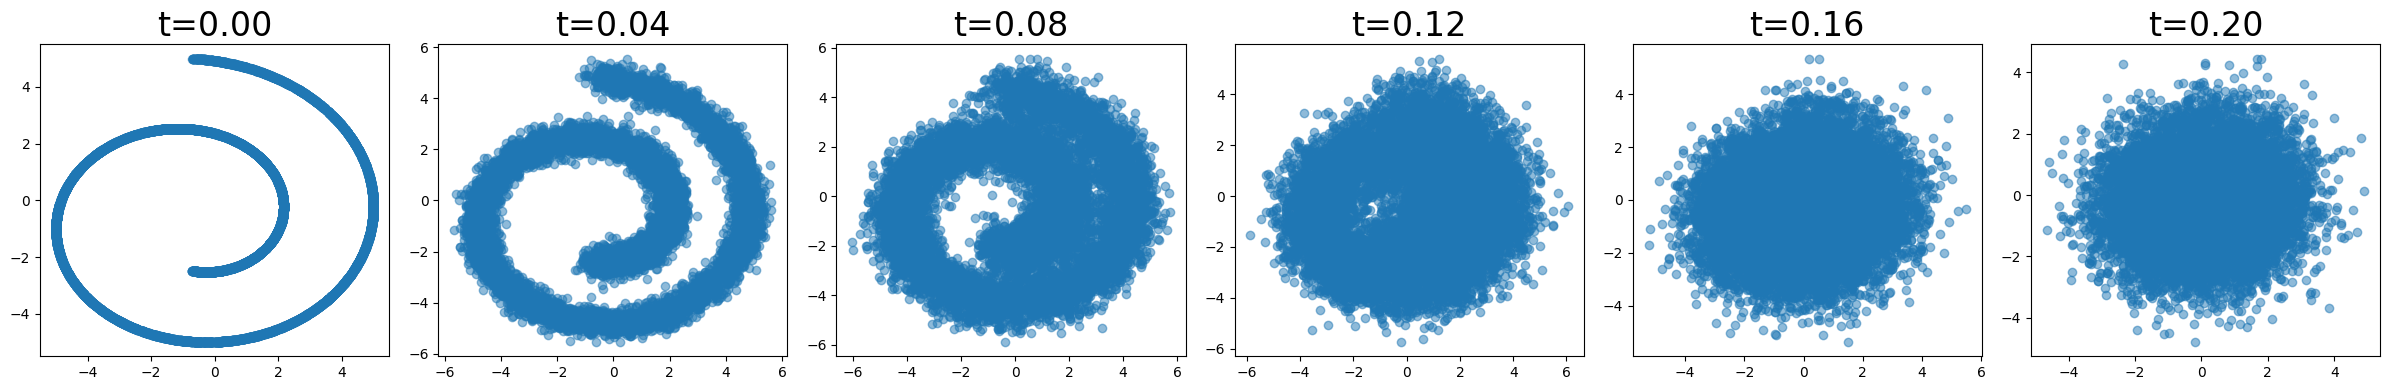

In [50]:

## visualize forward process
t_unit = T / N
t_schedule = np.arange(N + 1) * t_unit

# forward process
x_0 = true_data.sample(sample_size)
x_0 = torch.from_numpy(x_0).view(-1, data_dim)

x_t = list()

for t in t_schedule:

    x_t.append(model.forward_sde(x_0, t, to_numpy=True))

x_t = np.stack(x_t, axis=0)

visualize_diffusion_process_2d(xs=x_t, titles=[f"t={t:.2f}" for t in t_schedule], savename=None)


## Train the score matching model

begin to train


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:536: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Step [1000/20000], lr=1.00e-02: loss = 1.41e+00
Step [2000/20000], lr=1.00e-02: loss = 1.37e+00
Step [3000/20000], lr=1.00e-02: loss = 1.34e+00
Step [4000/20000], lr=1.00e-02: loss = 1.32e+00
Step [5000/20000], lr=1.00e-02: loss = 1.29e+00
Step [6000/20000], lr=1.00e-02: loss = 1.33e+00
Step [7000/20000], lr=1.00e-02: loss = 1.31e+00
Step [8000/20000], lr=1.00e-02: loss = 1.30e+00
Step [9000/20000], lr=5.00e-03: loss = 1.28e+00
Step [10000/20000], lr=5.00e-03: loss = 1.29e+00
Step [11000/20000], lr=5.00e-03: loss = 1.26e+00
Step [12000/20000], lr=5.00e-03: loss = 1.22e+00
Step [13000/20000], lr=5.00e-03: loss = 1.28e+00
Step [14000/20000], lr=5.00e-03: loss = 1.27e+00
Step [15000/20000], lr=5.00e-03: loss = 1.29e+00
Step [16000/20000], lr=5.00e-03: loss = 1.23e+00
Step [17000/20000], lr=2.50e-03: loss = 1.24e+00
Step [18000/20000], lr=2.50e-03: loss = 1.21e+00
Step [19000/20000], lr=2.50e-03: loss = 1.25e+00
Step [20000/20000], lr=2.50e-03: loss = 1.22e+00


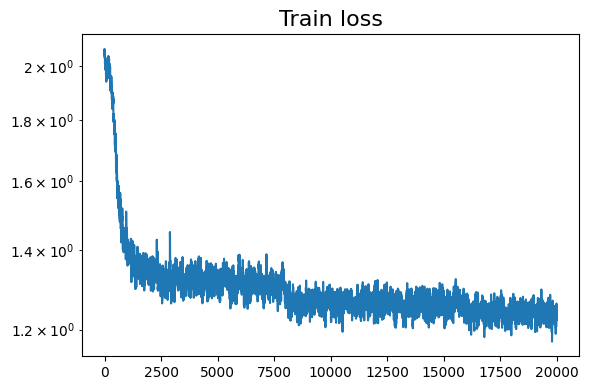

finish training
model saved to ckpts/sde_swissroll_2D_T-0.20_trainsteps-20000_bs-400_hdim-50/sde.pth


In [51]:
# If model exists, load it
if os.path.exists(os.path.join(ckpt_dir, "sde.pth")):
    model.load_state_dict(torch.load(os.path.join(ckpt_dir, "sde.pth")))
    print(f"model loaded from {os.path.join(ckpt_dir, 'sde.pth')}")

# otherwise, train it
else:
    print(f"begin to train")
    model.estimate_score(data_iter=true_data.data_iter(batch_size=batch_size, maxiter=steps), steps=steps, lr=1e-2)
    print(f"finish training")

    torch.save(model.state_dict(), os.path.join(ckpt_dir, "sde.pth"))
    print(f"model saved to {os.path.join(ckpt_dir, 'sde.pth')}")

## Visualize the reverse process

sampling with alpha=0.00 done, cost 141.83s
sampling with alpha=1.00 done, cost 141.56s
sampling with alpha=2.00 done, cost 143.33s
sampling with alpha=3.00 done, cost 140.51s
sampling with alpha=4.00 done, cost 136.00s


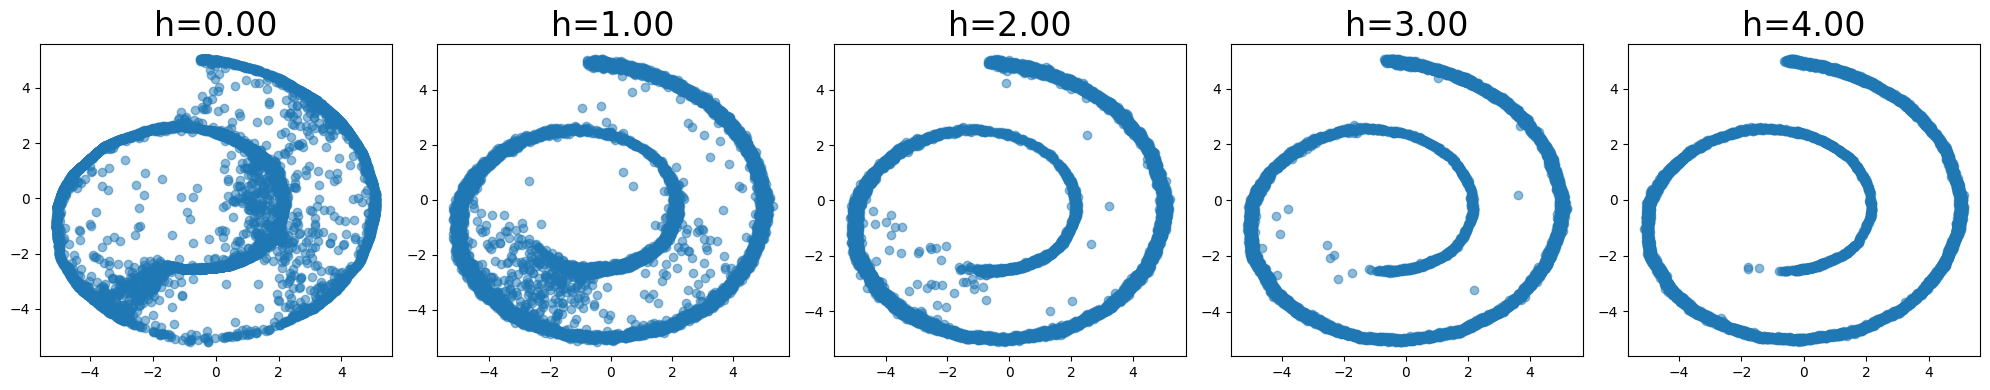

In [52]:
reverse_N = 20000
h_alphas = [0.0, 1.0, 2.0, 3.0, 4.0]

x_T = torch.randn(sample_size, data_dim)

# reverse process

tilde_x_t = list()

for h_alpha in h_alphas:

    tic = time.time()
    tilde_x_t.append(model.sample(x_t=x_T, T=0.0, N=reverse_N, to_numpy=True, sf_alpha=h_alpha))
    toc = time.time()

    print(f"sampling with alpha={h_alpha:.2f} done, cost {toc - tic:.2f}s")

tilde_x_t = np.stack(tilde_x_t, axis=0)

visualize_diffusion_process_2d(xs=tilde_x_t, titles=[f"h={h:.2f}" for h in h_alphas], savename=None)

## Evaluate

h=4.00: js=0.3897, kl=0.0077, wd=0.0013
h=3.56: js=0.3954, kl=0.0104, wd=0.0014
h=3.11: js=0.4091, kl=0.0081, wd=0.0017
h=2.67: js=0.4181, kl=0.0093, wd=0.0020
h=2.22: js=0.4248, kl=0.0062, wd=0.0024
h=1.78: js=0.4311, kl=0.0062, wd=0.0030
h=1.33: js=0.4363, kl=0.0062, wd=0.0037
h=0.89: js=0.4446, kl=0.0053, wd=0.0041
h=0.44: js=0.4748, kl=0.0116, wd=0.0043
h=0.00: js=0.5425, kl=0.0342, wd=0.0045


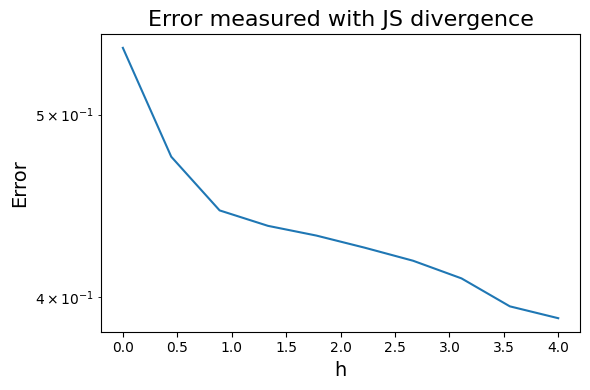

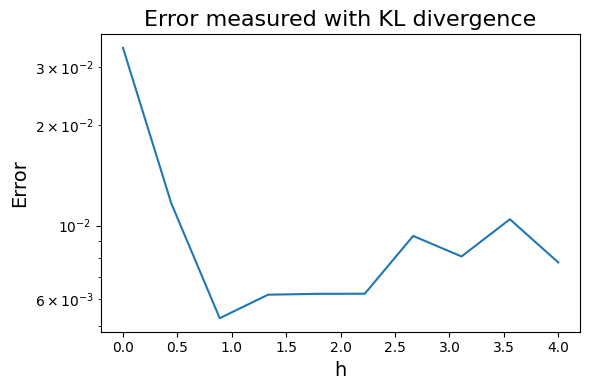

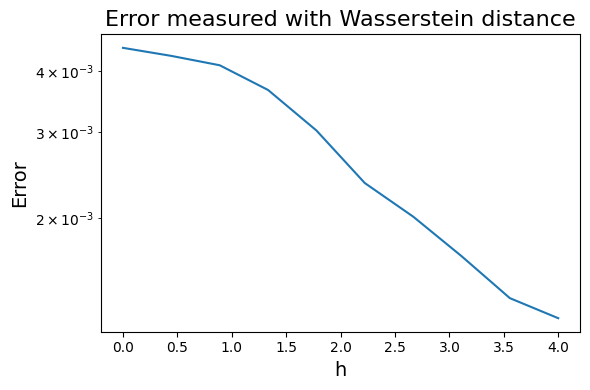

In [54]:
data = list()

for h in np.linspace(start=0.0, stop=h_alphas[-1], num=10, endpoint=True)[::-1]:
# for sa in [sf_alpha]:

    x_0 = true_data.sample(sample_size)
    x_0 = torch.from_numpy(x_0).view(-1, data_dim)

    x_0_gen = model.sample(x_t=x_T, T=0, N=reverse_N, to_numpy=True, sf_alpha=h)

    js, kl, wd = evaluate_2d(true_data=x_0.detach().numpy(), fake_data=x_0_gen, x0=x0, x1=x1, y0=y0, y1=y1)

    print(f"h={h:.2f}: js={js:.4f}, kl={kl:.4f}, wd={wd:.4f}")

    data.append([h, js, kl, wd])

data = np.array(data)

visualize_line(data=data[:, 1], yscale="log", xaxis=data[:, 0], xl=r"$\mathsf{h}$", yl="Error", title="Error measured with JS divergence", savename=None)
visualize_line(data=data[:, 2], yscale="log", xaxis=data[:, 0], xl=r"$\mathsf{h}$", yl="Error", title="Error measured with KL divergence", savename=None)
visualize_line(data=data[:, 3], yscale="log", xaxis=data[:, 0], xl=r"$\mathsf{h}$", yl="Error", title="Error measured with Wasserstein distance", savename=None)

